# Environment Setup

In [1]:
%matplotlib inline
import time
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
env = gym.make('CartPole-v1', render_mode='human')

In [3]:
env.reset()

for step in range(100):

    env.render()
    
    action = env.action_space.sample()
    observation, _, done, _, _ = env.step(action)

    time.sleep(0.001)
    
    if done:
        env.reset()
        break


"""
    While using render_mode="human" env.close() will clear everything about the environment 
    and won't let you use it for anything else.
"""
env.close()

# Hyperparameter Initialization

In [4]:
# The more bins you have, the more fine grain the search space and the more your agent can learn
# however, the larger the q table, the more training time is needed as the search space is larger. 
def create_observation_bins(num_bins_per_observation=10):
    bins_cart_position = np.linspace(-4.8, 4.8, num_bins_per_observation)
    bins_cart_velocity = np.linspace(-5, 5, num_bins_per_observation)
    bins_pole_angle = np.linspace(-0.418, 0.418, num_bins_per_observation)
    bins_pole_angular_velocity = np.linspace(-5, 5, num_bins_per_observation)

    bins = np.array([bins_cart_position, bins_cart_velocity, bins_pole_angle, bins_pole_angular_velocity])
    
    return bins

In [5]:
NUM_BINS = 10
BINS = create_observation_bins(NUM_BINS)

In [6]:
# Our observations for this problem (and many) are continuous, therefore creating our Q table like before
# requires a little more work, we obviously don't want an array or matrix index for every single value, when
# some values are very close to each other (1.1, 1.0, 0.9), we want a way to make those values discrete,
# so that we can get a more general idea what values we're getting

def discretize_observation(observations, bins):

    binned_observations = []

    for i, observation in enumerate(observations):
        # observations is in [cart_position, cart_velocity, pole_angle, pole_angular_velocity]
        # our bins were organized in the same way, thus observation[0] corresponds to bins[0]
        discretized_observation = np.digitize(observation, bins[i])

        binned_observations.append(discretized_observation)

    return tuple(binned_observations)

In [7]:
# Let's test if our discretization function works logically
# If we reset the env, our observation should be all the initial values, 
# which correspond to the middle of all the ranges we created with our bins (5)
# so we should expect that our discretized observations all be 5
env = gym.make('CartPole-v1', render_mode='rgb_array')
observation, _ = env.reset()
print(f'Raw (continuous) observation: {observation}')
mapped_observation = discretize_observation(observation, BINS)
print(f'Mapped (discrete) observation: {mapped_observation}')

Raw (continuous) observation: [-0.04738824 -0.00390713 -0.01348948 -0.00821447]
Mapped (discrete) observation: (5, 5, 5, 5)


In [8]:
# Initializing our Q Table:
# Our Q table will have one dimention per observation and the last one is for the number of actions (in this case 2)
q_table_shape = (NUM_BINS, NUM_BINS, NUM_BINS, NUM_BINS, env.action_space.n)
q_table = np.zeros(q_table_shape)
print(q_table.shape)

(10, 10, 10, 10, 2)


In [9]:
# Also referred to as EPOCHS, 
# running for a few thousands is how many times 
# it takes the agent of playing the game to start showing results
EPISODES = 20000 

# The LEARNING RATE, too low converges too fast, too high converges too quick
ALPHA = 0.8

# The DISCOUNT RATE, applied to 'future' rewards, so that recent rewards are worth more
GAMMA = 0.95

In [10]:
# For the epsilon-greedy algorithm
# Epsilon will start at the max value and will decrease to no less than the min value
# based on a function that we choose (in this case exponential decay)
# and we also state the rate of decay
epsilon = 1.0
BURN_IN = 1
EPSILON_END = 10000
EPSILON_REDUCE = 0.0001

# Update Functions

In [11]:
def epsilon_greedy_action_selection(epsilon, q_table, discrete_state):
    """
        Explaining Epsilon-Greedy Logic: 
        Since epsilon starts at 1.0, and our random number generator doesn't include 1.0 and
        we're using an exponential decay function for our epsilon, for the beginning we will 
        be mostly exploring a lot (AKA choosing the random action). However, as epsilon gets
        smaller over time, we will be exploiting what we've learned more and more, and exploring
        only very little.
    """

    random_number = np.random.random()

    # EXPLOITATION (choose the action that maximizes Q)
    if random_number > epsilon:

        # For the given (discrete) state, grab that state,
        # minor change from the previous example 
        # where we wanted the whole row, and we still
        # grab the index of the highest value
        action = np.argmax(q_table[discrete_state])
        
    # EXPLORATION (choose a random action)
    else:
        action = env.action_space.sample()

    return action

In [12]:
def compute_next_q_value(old_q_value, reward, next_optimal_q_value):
    """
        Q-Learning Update Equation
    """
    return old_q_value + ALPHA*(reward + GAMMA*next_optimal_q_value - old_q_value)

In [13]:
def reduce_epislon(epsilon, episode):
    """
        A Linear function to reduce epsilon
        BURN_IN is when we will start to reduce epsilon and
        EPSILON_END is when we stop reducing epsilon
        in between epsilon will be reduced linearly
        and this way, we allow some exploration before
        we start exploiting what we already know.
    """
    if BURN_IN <= episode <= EPSILON_END:
        epsilon -= EPSILON_REDUCE

    return epsilon

In [14]:
def failure(done, points, reward):
    """
        This function allows us to modify the reward for the agent
        vanilla cart pole continuously gives a reward as long as
        the cart is moving, however we want to add something to
        heavily punish the agent for not getting enough 'points' 
        (will be defined later). This can be modified even further
        based on the other observations if we so choose. This is
        just an introduction to creating or own reward system.
    """
    if done and points < 150:
        reward = -200
        
    return reward

# Agent Training & Visualization

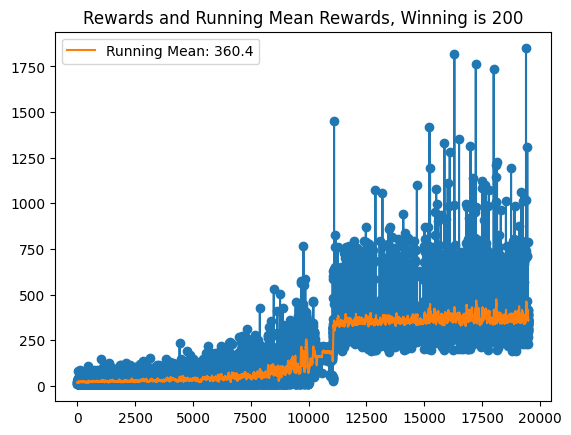

In [15]:
# Reinitialize the environment to render_mode='rgb_array' so that it's not wasting time rendering the game
env = gym.make('CartPole-v1', render_mode='rgb_array')

# For game visualization
render_interval = 30000

# For plotting purposes
log_interval = 500 
points_log = []
mean_points_log = []
episodes = []

# Start training the Agent
for episode in range(EPISODES):
    
    # Initialize everyting
    initial_state = env.reset()[0]
    discretized_state = discretize_observation(initial_state, BINS)
    done = False
    points = 0
    episodes.append(episode)

    # Play the game
    while not done:
        
        action = epsilon_greedy_action_selection(epsilon, q_table, discretized_state)
        next_state, reward, done, _, _ = env.step(action)

        # We want to adjust our reward with our own reward function
        reward = failure(done, points, reward)

        # We need to make the next state discrete
        next_discretized_state = discretize_observation(next_state, BINS)

        # Grab the old (current) Q value
        old_q_value = q_table[discretized_state + (action,)]

        # Grab the max (optimal) Q value from the table
        next_optimal_q_value = np.max(q_table[next_discretized_state])

        # Compute the next Q value
        next_q_value = compute_next_q_value(old_q_value, reward, next_optimal_q_value)

        # Add it to the table
        q_table[discretized_state + (action,)] = next_q_value

        # Set move forward by updating the state
        discretized_state = next_discretized_state
        points += 1

    epsilon = reduce_epislon(epsilon, episode)
    points_log.append(points)
    # Grabs the last 30 points in points_log and takes the average up to 2 decimal points
    running_mean = round(np.mean(points_log[-30:]), 2)
    mean_points_log.append(running_mean)

    if episode % log_interval == 0:
        clear_output(wait=True)
        plt.title('Rewards and Running Mean Rewards, Winning is 200')
        plt.scatter(episodes, points_log[:len(episodes)])
        plt.plot(episodes, points_log[:len(episodes)])
        plt.plot(episodes, mean_points_log[:len(episodes)], label=f'Running Mean: {running_mean}')
        plt.legend()
        plt.show()
        
env.close()

In [16]:
# To view the agent play the game, lets render it as human
env = gym.make('CartPole-v1', render_mode='human')
observation = env.reset()[0]
rewards = 0

for step in range(1000):
    env.render()
    discrete_state = discretize_observation(observation, BINS)
    action = np.argmax(q_table[discrete_state])
    observation, reward, done, _, _ = env.step(action)
    rewards += 1
    if done:
        print(f"Total Rewards: {rewards}")
        break
        
env.close()

Total Rewards: 368
